# NLP Group 8



## Literature Shelves and Relations

Colab link -> https://colab.research.google.com/drive/18_i2Nplb3wEUVpyr8Dp-S38sL0YWFfX2?usp=sharing

Q.

Assume that you were given 10,000 Research papers to read in a bundle, completely un-assorted! Your first job would
be to assort them in some hierarchical order, wherein these papers were separated in different sections/shelves. You are
given some Computer Science Research papers with their metadata including metadata, The task is to assort them in
shelves and sub-shelves. For example: You are given papers A,B,Z,1,2,-1,@,# At the level 1 the clusters could distinct
based on character types, (A,B,Z), (1,2-1), (@,#), Further the cluster (1,2,-1) can be divided into ((1,2), (-1)) and so on.

## Import Data and Libraries

In [ ]:
# Import Necessary libraries

import nltk
import pandas as pd
import sklearn
import scipy
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from matplotlib import pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from scipy.sparse import csr_matrix
from collections import Counter
import random
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Read and Display the data

data_df = pd.read_json('/content/drive/MyDrive/NLP/assignment_dump.json')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   abstract    64703 non-null   object
 1   authors     100000 non-null  object
 2   n_citation  100000 non-null  int64 
 3   references  100000 non-null  object
 4   title       100000 non-null  object
 5   venue       100000 non-null  object
 6   year        100000 non-null  int64 
 7   id          100000 non-null  object
dtypes: int64(2), object(6)
memory usage: 6.1+ MB


In [ ]:
# Extract the required columns for this task

df_category = data_df.drop(columns=['n_citation', 'references', 'authors', 'year', 'id'])
df_category.head()

,abstract,title,venue
0,This paper describes the design and implementa...,A methodology for the physically accurate visu...,visual analytics science and technology
1,This article applied GARCH model instead AR or...,"Comparison of GARCH, Neural Network and Suppor...",pattern recognition and machine intelligence
2,"Recently, Bridges and Reich introduced the con...",Multisymplectic Spectral Methods for the Gross...,international conference on conceptual structures
3,Most applications of the abstract interpretati...,Relational Abstract Interpretation of Higher O...,
4,This paper focuses on knowledge engineering fo...,Knowledge Engineering for Affective Bi-Modal I...,joint conference on knowledge-based software e...


## Text Processing Functions

In [ ]:
# Functon for tokenizeing sentences

def tokenize(text):
  if type(text) is str:
    return [word for word in word_tokenize(text.lower()) if word.isalpha()]
  else:
    return text

In [ ]:
# Defining Stop words and customizing them

stopwords_english = stopwords.words('english')
stopwords_english.extend(['international', 'conference', 'national', 'association', 'joint', 'european', 'principle', 'principal', 'lecture', 'notes'])

In [ ]:
# Stopwords removal Function
def remove_stopwords(word_list):
  rem_stopwords = []

  if type(word_list) is not list:
    return []
  
  # remove computer science from the text
  i = 0
  while i < len(word_list):
    if i < len(word_list) - 1 and word_list[i] == 'computer' and word_list[i + 1] == 'science':
      i += 2
      continue
    
    if i < len(word_list) - 1 and word_list[i] == 'ad' and word_list[i + 1] == 'hoc':
      i += 2
      continue
    
    if not word_list[i] in stopwords_english:
      rem_stopwords.append(word_list[i])

    i += 1

  return rem_stopwords

In [ ]:

# Function for lemmatizing

def lemmatize(word_list):
  lemmatized = []

  if type(word_list) is not list:
    return []

  for word in word_list:
    lemma = wordnet.morphy(word)
    if lemma is not None:
      lemmatized.append(lemma)
    else:
      lemmatized.append(word)

  return lemmatized

In [ ]:
# To reform sentences from lists

def reform_text(word_list):
  if not type(word_list) is list:
    return ""

  text = ""

  for word in word_list:
    text += word + " "

  return text

In [ ]:
# Combining above to form preprocessing functions

def preprocess_text(text):
  tokens = tokenize(text)
  n_stopwords = remove_stopwords(tokens)
  lemm_vec = lemmatize(n_stopwords)
  lemm_text = reform_text(lemm_vec)
  return lemm_text

def preprocess_text_series(column):
  tokenized_series = column.apply(tokenize)
  n_stopwords = tokenized_series.apply(remove_stopwords)
  lemm_series = n_stopwords.apply(lemmatize)
  lemm_text = lemm_series.apply(reform_text)
  return lemm_text

## K Means Helper Functions

In [ ]:
# find knee point from series of data

def find_knee_point(distortions, n_entries):

  val = None

  for i in range(4, n_entries - 1):

    prev_grad = distortions[i - 1] - distortions[i]
    new_grad = distortions[i] - distortions[i + 1]

    if new_grad < 0:
      continue

    if val is None:
      val = new_grad
      knee_point = i + 1
    
    if new_grad < val:
      val = new_grad
      knee_point = i + 1

  return knee_point

In [ ]:
'''

Function to find number of clustes for kmeans

The functions goes through possible cluster values 
and uses the elbow method to pick up the optimal no of clusters for the data

'''

def find_req_clusters(series, n_try_clusters=15):

  # do kmeans and store the data
  distortions = []
  for i in range(0, n_try_clusters):
      km = MiniBatchKMeans(
          n_clusters=i + 1, init='k-means++',
          n_init=10, max_iter=300,
          tol=1e-04, random_state=0
      )
      km.fit(series)
      distortions.append(km.inertia_)

  return find_knee_point(distortions, n_try_clusters)

In [ ]:
'''
Alternative method using yellow bricks library for kneepoint
'''

def optimal_clusters_elbow(series, n_try_clusters=15):

  km = MiniBatchKMeans(init='random', n_init=10, max_iter = 300, tol=1e-04)
  model = KElbowVisualizer(km, k=n_try_clusters, metric='silhouette')
  model.fit(series)
  model.show()
  return model.elbow_value_

In [ ]:
# After forming the clusters, this functions assign each document to a cluster
# The document is assigned to the cluster which has the nearest centroid

def assign_centroid(x, clusters):

  x_arr = x.toarray()

  c_index = 0
  min_dist = np.linalg.norm(clusters[0] - x_arr)

  for i in range(clusters.shape[0]):
    dist = np.linalg.norm(clusters[i] - x_arr)
    if dist < min_dist:
      min_dist = dist
      c_index = i

  return c_index

In [ ]:
# Function for assigning categories to docs which were not assigned

def assign_category_to_empty(title, category1, vectorzier, clusters, text_categories):
  if not category1 is "":
    return category1

  title_vec = vectorizer.transform(title)

  c_index = assign_centroid(title_vec, clusters)
  return  text_categories[c_index]

## K-Means


**Approach for 1st Level Classification**

We took the venue field from the data and used it's value for forming the First Level of Categories

For further levels, we start taking other fields of data for a total of three levels

In [ ]:
'''

The first iteration for the major headings

'''

major_headings = []

# Extracting the relevant column
df_kmeans = pd.DataFrame()
df_kmeans['text'] = df_category['venue']

# drop empty rows

df_kmeans['text'].replace('', np.nan, inplace=True)
df_kmeans.dropna(subset=['text'], inplace=True)

print("Preprocessing text")

# preprocess text
df_kmeans['text'] = preprocess_text_series(df_kmeans['text'])

print("Text Processing done")

# vectorize text
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(2, 2))
kmeans_vector = vectorizer.fit_transform(df_kmeans['text'])

print("Text Vectorization done")

# use csr representation to find centroids
req_clusters = find_req_clusters(kmeans_vector)

print("Optimal Numbers of Cluster: ", req_clusters)

# fit the data to kmeans
km = KMeans(
  n_clusters=req_clusters, init='k-means++',
  n_init=10, max_iter=300, 
  tol=1e-04, random_state=0
)

km.fit(kmeans_vector)

# form id_word mapping to be used later
id_word_vocab = {}

for kv_pair in vectorizer.vocabulary_.items():
  id_word_vocab[kv_pair[1]] = kv_pair[0]

# store csr back to dataframe

df_kmeans['text'] = pd.Series(list(kmeans_vector[:]), index=df_kmeans.index)

# form categories from centroids
text_categories = []

for cluster in km.cluster_centers_:
  category = ""

  # we choose the most prominent bigram as the category
  category = id_word_vocab[np.argmax(cluster)]

  text_categories.append(category)

print("Cateogries generated")
print(text_categories)

# Store categories to be used later
major_headings = text_categories

clusters = scipy.sparse.csr_matrix(km.cluster_centers_)

# assign each document to a centroid
df_kmeans['centroid'] = df_kmeans['text'].apply(lambda x: assign_centroid(x, clusters))

df_kmeans['Category 1'] = df_kmeans['centroid'].apply(lambda x: text_categories[x])

# store the results back to df_category
df_kmeans = df_kmeans.reindex([i for i in range(len(df_category))], fill_value="")

df_category['Category 1'] = df_kmeans['Category 1']

del df_kmeans

print(df_category[['title', 'Category 1']].sample(20))


Preprocessing text
Text Processing done
Text Vectorization done
Optimal Numbers of Cluster:  13
Cateogries generated
['artificial intelligence', 'information system', 'processing management', 'speech communication', 'machine learning', 'soft computing', 'conceptual structure', 'data mining', 'language processing', 'information system', 'computer vision', 'installation system', 'language resource']
                                                   title               Category 1
63596  Effects of Manual Phonetic Transcriptions on R...       information system
29494                       Force-Directed Graph Drawing                         
70014  Crossing the streams: a framework for streamin...       information system
33813  Computational aspects of covering in dominance...  artificial intelligence
57564  An Abstract Image Representation Based on Edge...       information system
11773  PRISM: a parallel inference system for problem...  artificial intelligence
71091  On the Impossibili

Now, we assign those documents which do not have venue to a category.

For this we use the same vectorizer to transform the titled field of these papers and then assign them to clusters

In [ ]:
# assign a category to those who does not have a venue
df_no_venue = df_category[df_category['venue'] == '']

# preprocess and vectorize the title of the paper and assign the paper to the centroid which is nearest to it's title
df_no_venue['text'] = preprocess_text_series(df_no_venue['title'])
title_vector = vectorizer.transform(df_no_venue['text'])

# convert csr back to normal vector
df_no_venue['text'] = pd.Series(list(title_vector[:]), index=df_no_venue.index)

# assign each document to a centroid
df_no_venue['centroid'] = df_no_venue['text'].apply(lambda x: assign_centroid(x, km.cluster_centers_))

df_no_venue['Category 1'] = df_no_venue['centroid'].apply(lambda x: text_categories[x])

# store the results back to df_category
df_category.loc[df_category['Category 1'] == '', 'Category 1'] = df_no_venue['Category 1']

del df_no_venue

print(df_category[['title', 'Category 1']].sample(20))

                                                   title            Category 1
86789  Access Control Model Based on RDB Security Pol...  conceptual structure
19758         Data Ranking Based on Spatial Partitioning    information system
5153   The Supported Solutions Used as a Genetic Info...    information system
63395  Comparison of Greedy Algorithms for Decision T...    information system
81211  Probabilistic common cause failures in phased-...    information system
26818        A graph-kernel method for re-identification    information system
64601  Exploiting Interaction Features in User Intent...    information system
19183          Creating and Debugging Performance CUDA C    information system
37697  Automatic modeling of dominance effects using ...    information system
87280  2-R Regeneration Exploiting Self-Phase Modulat...    information system
29113  On the resolution complexity of graph non-isom...    information system
97037  On the Design of a Watermarking System: Consi

In [ ]:
for heading in major_headings:
  print(heading, len(df_category[df_category['Category 1'] == heading]['title']))

artificial intelligence 4988
information system 87438
processing management 167
speech communication 2480
machine learning 529
soft computing 599
conceptual structure 316
data mining 861
language processing 328
information system 87438
computer vision 1357
installation system 127
language resource 810


**Approach for second level classification**

For the second level classification, we take all documents in a particular category and run the same process 
to form further subcategories

Two important distinctions from the first part is


*   Using Trigrams insted of Bigrams, because more words will lead to more specific categories
*   Using a min_df value. Initially the vocabulary size was too big(~4000000) and we reasoned it to be due to unique titles for every paper. So we switched to a value of min_df = 2, which means we only consider those terms who occur in more than 2 documents. This resulted in a vocabulary size of ~20000



In [ ]:
'''

Second iteration for the sub headings

'''

df_category['Category 2'] = ""

subheadings = []

for heading in major_headings:

  print("For category :", heading)

  df_kmeans = pd.DataFrame()

  df_kmeans['text'] = df_category[df_category['Category 1'] == heading]['title']

  # preprocess text
  df_kmeans['text'] = preprocess_text_series(df_kmeans['text'])

  print(df_kmeans.head())

  # vectorize text
  vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(3, 3), min_df=2)
  kmeans_vector = vectorizer.fit_transform(df_kmeans['text'])


  # use csr representation to find centroids
  req_clusters = find_req_clusters(kmeans_vector)

  print("Optimal Numbers of Cluster: ", req_clusters)

  km = KMeans(
    n_clusters=req_clusters, init='k-means++',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
  )

  km.fit(kmeans_vector)

  # store csr representation back to dataframe
  df_kmeans['text'] = pd.Series(list(kmeans_vector[:]), index=df_kmeans.index)

  # form vocab
  id_word_vocab = {}

  for kv_pair in vectorizer.vocabulary_.items():
    id_word_vocab[kv_pair[1]] = kv_pair[0]

  # form categories from centroids
  text_categories = []

  for cluster in km.cluster_centers_:
    category = ""

    category = id_word_vocab[np.argmax(cluster)]

    text_categories.append(category)

  print("Cateogries generated for heading: ", heading)
  print(text_categories)

  subheadings.extend(text_categories)

  # assign each document to a centroid
  df_kmeans['centroid'] = df_kmeans['text'].apply(lambda x: assign_centroid(x, km.cluster_centers_))

  df_kmeans['Category 2'] = df_kmeans['centroid'].apply(lambda x: text_categories[x])

  df_category.loc[df_category['Category 1'] == heading, 'Category 2'] = df_kmeans['Category 2']

  del df_kmeans

For category : artificial intelligence
                                                  text
25         general semantic analyser data base access 
60               search lesson learn crossword puzzle 
63   conceptual indexing practical ai efficient inf...
83   adaptive localization dynamic wifi environment...
121    machine learning adaptive image interpretation 
Optimal Numbers of Cluster:  10
Cateogries generated for heading:  artificial intelligence
['intelligent tutor system', 'constraint satisfaction problem', 'markov decision process', 'description logic ontology', 'word sense disambiguation', 'inference story understanding', 'terminology description logic', 'general game playing', 'coalition structure generation', 'learning bayesian network']
For category : information system
                                                text
0  methodology physically accurate visualisation ...
1  comparison garch neural network support vector...
3  relational abstract interpretation higher

In [ ]:
df_category.head()

,abstract,title,venue,Category 1,Category 2
0,This paper describes the design and implementa...,A methodology for the physically accurate visu...,visual analytics science and technology,information system,wireless sensor network
1,This article applied GARCH model instead AR or...,"Comparison of GARCH, Neural Network and Suppor...",pattern recognition and machine intelligence,information system,support vector machine
2,"Recently, Bridges and Reich introduced the con...",Multisymplectic Spectral Methods for the Gross...,international conference on conceptual structures,conceptual structure,ant colony optimization
3,Most applications of the abstract interpretati...,Relational Abstract Interpretation of Higher O...,,information system,wireless sensor network
4,This paper focuses on knowledge engineering fo...,Knowledge Engineering for Affective Bi-Modal I...,joint conference on knowledge-based software e...,information system,wireless sensor network


For part 3 we use both titles and abstract to cluster. 

The process remains the same, only difference is we also form a common vectorizer to later be used in second part

In [ ]:
subheadings = list(set(subheadings))

In [ ]:
category3_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(3, 3), min_df=3)
title_abstract = data_df['title'].fillna("") + " " + data_df['abstract'].fillna("")

title_abstract = preprocess_text_series(title_abstract)

# learn vocabulary
category3_vectorizer.fit(title_abstract)

TfidfVectorizer(min_df=3, ngram_range=(3, 3))

In [ ]:
'''

Third iteration for the sub sub headings

'''

df_category['Category 3'] = ""

subsubheadings = []

topic_clusters = {}

count = 0

for heading in subheadings:

  print("For category :", heading)

  df_kmeans = pd.DataFrame()

  df_kmeans['text'] = df_category[df_category['Category 2'] == heading]['abstract'].fillna("") + " " + df_category[df_category['Category 2'] == heading]['title'].fillna("")
  if(len(df_kmeans) < 10):
    print("Skipping due to lack of documents in category")
    subsubheadings.append(heading)

    count += 1
    print(count,"/",len(subheadings), "done")
    continue

  # preprocess text
  df_kmeans['text'] = preprocess_text_series(df_kmeans['text'])
  print(df_kmeans.head())

  # vectorize text
  kmeans_vector = category3_vectorizer.transform(df_kmeans['text'])


  # use csr representation to find centroids
  req_clusters = find_req_clusters(kmeans_vector, n_try_clusters=10)

  print("Optimal Numbers of Cluster: ", req_clusters)

  km = KMeans(
    n_clusters=req_clusters, init='k-means++',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
  )

  km.fit(kmeans_vector)

  df_kmeans['text'] = pd.Series(list(kmeans_vector[:]), index=df_kmeans.index)

  # form vocab
  id_word_vocab = {}

  for kv_pair in category3_vectorizer.vocabulary_.items():
    id_word_vocab[kv_pair[1]] = kv_pair[0]

  # form categories from centroids
  text_categories = []

  for cluster in km.cluster_centers_:
    category = ""

    category = id_word_vocab[np.argmax(cluster)]

    text_categories.append(category)
    topic_clusters[category] = cluster


  print("Cateogries generated for heading: ", heading)
  print(text_categories)

  subsubheadings.extend(text_categories)

  # assign each document to a centroid
  df_kmeans['centroid'] = df_kmeans['text'].apply(lambda x: assign_centroid(x, km.cluster_centers_))

  df_kmeans['Category 3'] = df_kmeans['centroid'].apply(lambda x: text_categories[x])

  df_category.loc[df_category['Category 2'] == heading, 'Category 3'] = df_kmeans['Category 3']


  count += 1
  print(count,"/",len(subheadings), "done")

  del df_kmeans


For category : data mining algorithm
Skipping due to lack of documents in category
1 / 85 done
For category : name entity recognition
                                                    text
1706   paper name entity recognition ner telugu much ...
4656              learning rule name entity recognition 
14709  second harem advance state art name entity rec...
18559  abstract stub paper talks new approach recogni...
20848  much work already do building name entity reco...
Optimal Numbers of Cluster:  8
Cateogries generated for heading:  name entity recognition
['multilingual name entity', 'name entity recognition', 'information management architecture', 'feature subset selection', 'recognition indian language', 'base ner system', 'entity recognition portuguese', 'south asian language']
2 / 85 done
For category : natural language processing
                                                    text
1421   detail problem list comply jcaho requirement i...
6663   paper present architecture t

**Part 2**


For the next step you need a citation graph of the given papers. The task is to find the citation graph, and possibly have
a mechanism to find what papers would some new literature cite. The output should be an adjacency matrix. [Note: You
can also use this concept to improve your literature shelves].

## Citation Graph

In [ ]:
citation_graph = csr_matrix((len(data_df), len(data_df)), dtype=np.int8)

In [ ]:
# create a map of id and index of all the papers

id_index_map = {}
for index, row in data_df.iterrows():
  id_index_map[row['id']] = index

In [ ]:
for index, row in data_df.iterrows():
  # get all the citations for a paper
  citations = row['references']
  for paper in citations:
    if paper not in id_index_map:
      continue
    citation_graph[index, id_index_map[paper]] = 1

The required adjacency matrix of part 2 is:

In [ ]:
print(citation_graph)

  (6, 36822)	1
  (6, 59884)	1
  (6, 66041)	1
  (8, 38659)	1
  (10, 56890)	1
  (11, 21826)	1
  (12, 11041)	1
  (12, 17944)	1
  (12, 65392)	1
  (22, 27769)	1
  (22, 49728)	1
  (25, 96483)	1
  (32, 20143)	1
  (33, 51271)	1
  (35, 41102)	1
  (35, 89118)	1
  (37, 8248)	1
  (37, 17164)	1
  (38, 12680)	1
  (38, 29630)	1
  (38, 30290)	1
  (38, 61859)	1
  (39, 60441)	1
  (39, 92693)	1
  (47, 21798)	1
  :	:
  (99917, 85568)	1
  (99918, 61719)	1
  (99922, 84773)	1
  (99929, 50705)	1
  (99936, 63420)	1
  (99940, 13322)	1
  (99940, 56836)	1
  (99941, 45822)	1
  (99941, 51191)	1
  (99943, 7217)	1
  (99943, 69079)	1
  (99957, 18889)	1
  (99957, 72084)	1
  (99957, 97102)	1
  (99960, 14336)	1
  (99963, 99274)	1
  (99969, 85462)	1
  (99969, 86825)	1
  (99969, 99320)	1
  (99978, 42732)	1
  (99985, 21748)	1
  (99985, 59755)	1
  (99985, 65132)	1
  (99988, 11957)	1
  (99994, 31809)	1


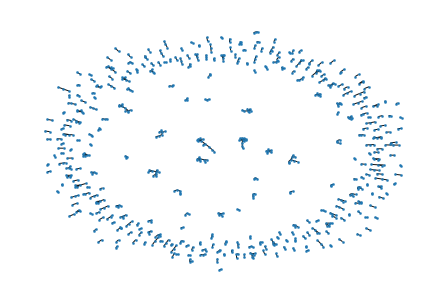

In [ ]:
import networkx as nx

cit_array = citation_graph[0:1000]

rows, cols = cit_array.nonzero()
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw(gr, node_size=5)
plt.show()

del cit_array

As seen in the graph above, a lot of paper citations were outside of the corpora given to us. This resulted in a lot of disjoint small clusters, So we decided not to use this to enhance our initial clustering method.

## Future Paper Citations algorithm

In [ ]:
test_paper = {
    "title": "Deep Residual Learning for Image Recognition",
    "authors":"Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun",
    "abstract": "Deeper neural networks are more difficult to train. We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously. We explicitly reformulate the layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions. We provide comprehensive empirical evidence showing that these residual networks are easier to optimize, and can gain accuracy from considerably increased depth. On the ImageNet dataset we evaluate residual nets with a depth of up to 152 layers---8x deeper than VGG nets but still having lower complexity. An ensemble of these residual nets achieves 3.57% error on the ImageNet test set. This result won the 1st place on the ILSVRC 2015 classification task. We also present analysis on CIFAR-10 with 100 and 1000 layers.",
    "link": "https://arxiv.org/abs/1512.03385"
}

The algorithm we used was for to assign each document to a subcategory. Then for each subcategory we take the most frequent citations and with a weight and random modifier to predict the citations.

In [ ]:

# find the vector representation of the paper title and abstract

paper_text = test_paper['title'] + " " + test_paper['abstract']
paper_text = preprocess_text(paper_text)

# print(paper_text)

paper_idf_vector = category3_vectorizer.transform([paper_text])
paper_idf_vector = paper_idf_vector.toarray()

# assign a subsubcaetgory to the paper

group = {}

for topic in topic_clusters:
  dist = np.linalg.norm(paper_idf_vector - topic_clusters[topic])
  group[topic] = -dist

# get the closest 3 clusters and get weights for all
# weight is eucledian distance between the document and cluster

cluster_weight = {}
near_clusters = []
for k, v in Counter(group).most_common(3):
  cluster_weight[k] = -v
  near_clusters.append(k)

# find all papers in that subsubcategory
print("Major cluster found with category: ", near_clusters)

df_filter = df_category[(df_category['Category 3'] == near_clusters[0]) | (df_category['Category 3'] == near_clusters[1]) | (df_category['Category 3'] == near_clusters[2])]

# find and return the 5 most frequently cited paper as results

dict_index_freq = {}

for index, row in df_filter.iterrows():
  citation_row = citation_graph[index]

  weight = cluster_weight[row['Category 3']]

  for cite in citation_row.nonzero()[1]:
    if cite in dict_index_freq:
      dict_index_freq[cite] +=  1 / weight
    else:
      dict_index_freq[cite] = 1 / weight

for key in dict_index_freq:
  dict_index_freq[key] = random.uniform(0, 1) * dict_index_freq[key]

# return the 5 most frequent results
possible_id = []
for k, v in Counter(dict_index_freq).most_common(5):
  possible_id.append(k)

# get titles of paper from possible id's
possible_papers = [df_category['title'][i] for i in possible_id]

print("Possible Citations for this paper are: ")
print(possible_papers)



Major cluster found with category:  ['convolutional neural network', 'index terms speech', 'markov decision process']
Possible Citations for this paper are: 
['Hard and easy distributions of SAT problems', 'Planning with Incomplete Information as Heuristic Search in Belief Space', 'Indoor segmentation and support inference from RGBD images', 'Generating project networks', 'A causal theory of ramifications and qualifications']


## Group Members
2018A7PS0038G	Nikhil Shishodia -> Citation graph + Algo

2018A7PS0117G	Aditya Mishra -> K Means Helper Functions

2018A7PS0233G	Nilesh Kumar Gupta -> K Means Main Loop

2018A7PS0630G	Soham Sachin Sarpotdar -> Text Preprocessing functions